In [63]:
import os
import pandas as pd
import re

# The base_path for your manifest files is the current directory '.'
# The image_folder is the name of the directory containing the image classes.
base_path = '.' 
image_folder = 'Garbage classification'

def load_split(filename):
    """
    Loads a manifest file, corrects label indexing, and prepares the DataFrame.
    """

    path = os.path.join(base_path, filename)
    df = pd.read_csv(path, sep=' ', header=None, names=['filename', 'label'])
    
    # Correct from one-indexed to zero-indexed
    df["label"] = df["label"] - 1 
    
    # Extract class name from filename (e.g., 'cardboard114.jpg' -> 'cardboard')
    df['class'] = df['filename'].apply(lambda x: re.match(r'^[a-zA-Z]+', x).group(0))
    
    # Construct the full, correct path to the image file
    df['filepath'] = df.apply(lambda row: os.path.join(image_folder, row['class'], row['filename']), axis=1)
    
    return df

train_df = load_split("one-indexed-files-notrash_train.txt")
val_df = load_split("one-indexed-files-notrash_val.txt")
test_df = load_split("one-indexed-files-notrash_test.txt")


print("--- Training DataFrame ---")
print(f"Total entries: {len(train_df)}")
print(train_df.head())

print("\n--- Validation DataFrame ---")
print(f"Total entries: {len(val_df)}")
print(val_df.head())

--- Training DataFrame ---
Total entries: 1768
           filename  label      class  \
0  cardboard202.jpg      2  cardboard   
1      paper472.jpg      1      paper   
2      paper522.jpg      1      paper   
3      glass189.jpg      0      glass   
4      glass325.jpg      0      glass   

                                            filepath  
0  Garbage classification\cardboard\cardboard202.jpg  
1          Garbage classification\paper\paper472.jpg  
2          Garbage classification\paper\paper522.jpg  
3          Garbage classification\glass\glass189.jpg  
4          Garbage classification\glass\glass325.jpg  

--- Validation DataFrame ---
Total entries: 328
           filename  label      class  \
0  cardboard114.jpg      2  cardboard   
1    plastic204.jpg      3    plastic   
2      glass123.jpg      0      glass   
3      glass152.jpg      0      glass   
4      glass398.jpg      0      glass   

                                            filepath  
0  Garbage classification

In [64]:
print(train_df['class'].isnull().sum())
print(val_df['class'].isnull().sum())
print(test_df['class'].isnull().sum())

0
0
0


In [65]:
train_df.shape

(1768, 4)

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1768 non-null   object
 1   label     1768 non-null   int64 
 2   class     1768 non-null   object
 3   filepath  1768 non-null   object
dtypes: int64(1), object(3)
memory usage: 55.4+ KB


In [67]:
train_df.drop(columns=['filepath'], inplace=True)
val_df.drop(columns=['filepath'], inplace=True)
test_df.drop(columns=['filepath'], inplace=True)


In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1768 non-null   object
 1   label     1768 non-null   int64 
 2   class     1768 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.6+ KB


In [69]:
train_df.shape

(1768, 3)

In [70]:
AUG_FACTOR = 4     

trash_df      = train_df[train_df['label'] == 5]
augmented_df  = pd.concat([train_df] + [trash_df] * AUG_FACTOR, ignore_index=True)
print("Augmentation", augmented_df['class'].value_counts())

Augmentation class
trash        455
paper        403
glass        354
plastic      347
cardboard    287
metal        286
Name: count, dtype: int64


In [71]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import load_img

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

@tf.function
def augment_if_trash(image, label):
    image = tf.image.resize(image, IMG_SIZE)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.05)

    def heavy(img):
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_contrast(img, .8, 1.2)
        img = tf.image.random_saturation(img, .8, 1.2)
        img = tf.image.random_hue(img, .05)
        return img
    image = tf.cond(tf.equal(label, 5), lambda: heavy(image), lambda: image)

    image = tf.clip_by_value(image, 0., 255.)
    image = preprocess_input(image) 
    return image, label

In [72]:
def df_to_ds(df, shuffle=True):
    paths  = df.apply(lambda r: os.path.join(base_path_img,
                                             r['class'],
                                             r['filename']), axis=1)
    labels = df['label'].astype('int32')

    ds = tf.data.Dataset.from_tensor_slices((paths.values, labels.values))

    def _load(path, lab):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        return img, lab

    ds = ds.map(_load,  num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(augment_if_trash, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(len(df))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_ds(augmented_df, shuffle=True)
val_ds = df_to_ds(val_df,shuffle=False)
test_ds = df_to_ds(test_df,shuffle=False)

In [73]:
y_aug = augmented_df['label'].values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_aug),
    y=y_aug
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

{0: np.float64(1.0037664783427496), 1: np.float64(0.8817204301075269), 2: np.float64(1.2380952380952381), 3: np.float64(1.0240153698366954), 4: np.float64(1.2424242424242424), 5: np.float64(0.780952380952381)}


['cardboard' 'paper' 'glass' 'metal' 'trash' 'plastic']
6


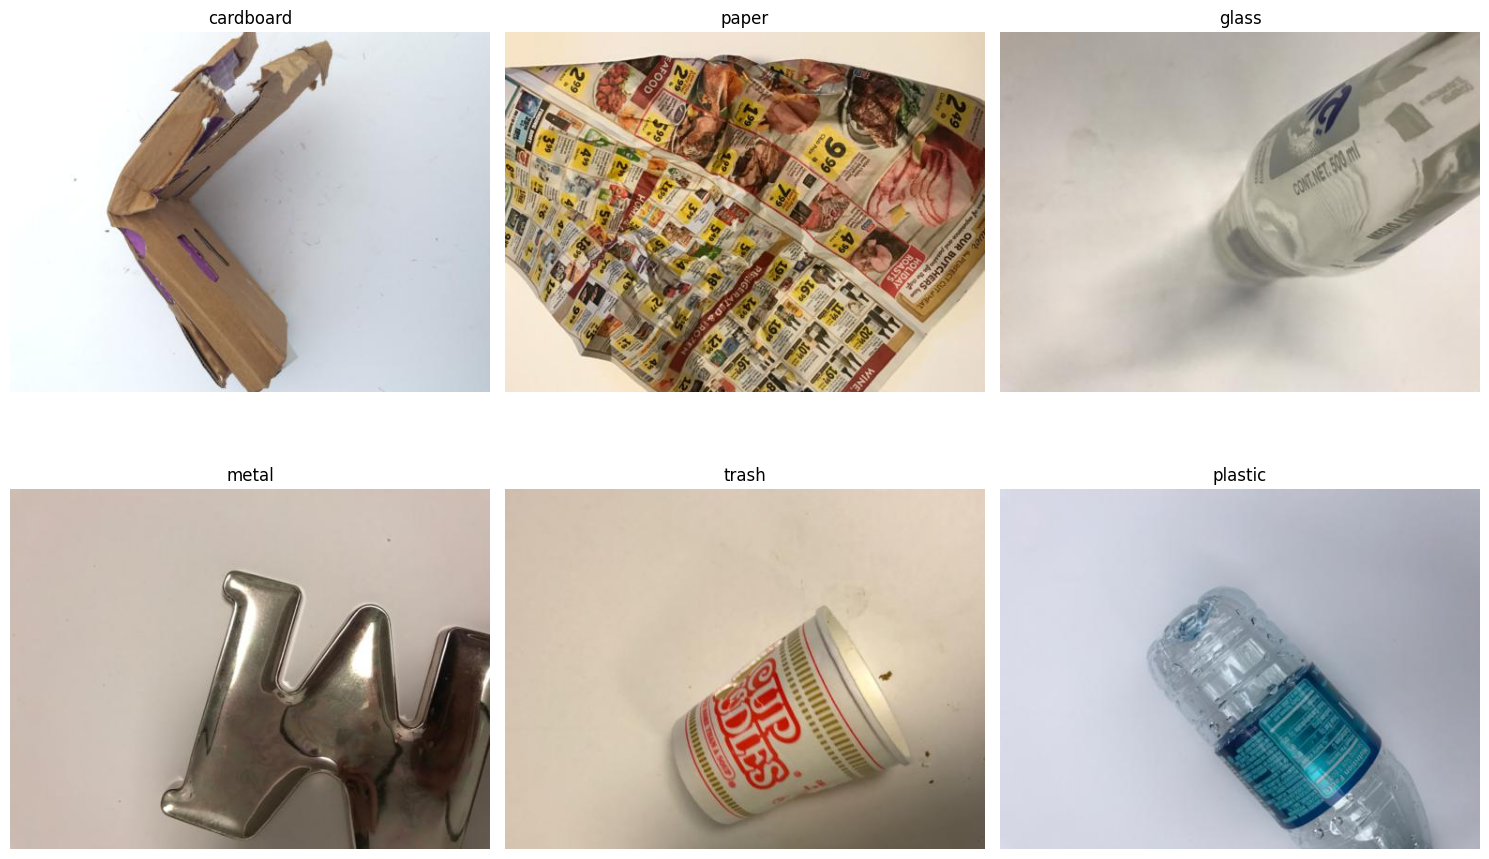

In [74]:
import matplotlib.pyplot as plt
base_path_img = 'Garbage classification'

classes = train_df['class'].dropna().unique()

print(classes)
print(len(classes))

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    cls = classes[i]
    sample_row = train_df[train_df['class'] == cls].iloc[0]
    img_path = os.path.join(base_path_img, sample_row['class'], sample_row['filename'])
    img = load_img(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [75]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = False


model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax') 
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,132,230 (92.06 MB)

 Trainable params: 562,822 (2.15 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

In [76]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.2461 - loss: 8.2992
Epoch 1: val_loss improved from None to 6.78272, saving model to best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 76s 994ms/step - accuracy: 0.3194 - loss: 7.9011 - val_accuracy: 0.6250 - val_loss: 6.7827 - learning_rate: 3.0000e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.4999 - loss: 6.8941
Epoch 2: val_loss improved from 6.78272 to 6.07254, saving model to best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5403 - loss: 6.6921 - val_accuracy: 0.7165 - val_loss: 6.0725 - learning_rate: 3.0000e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.5966 - loss: 6.2539
Epoch 3: val_loss improved from 6.07254 to 5.52189, saving model to best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.6041 - loss: 6.1016 - val_accuracy: 0.7835 - val_loss: 5.5219 - learning_rate: 3.0000e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc

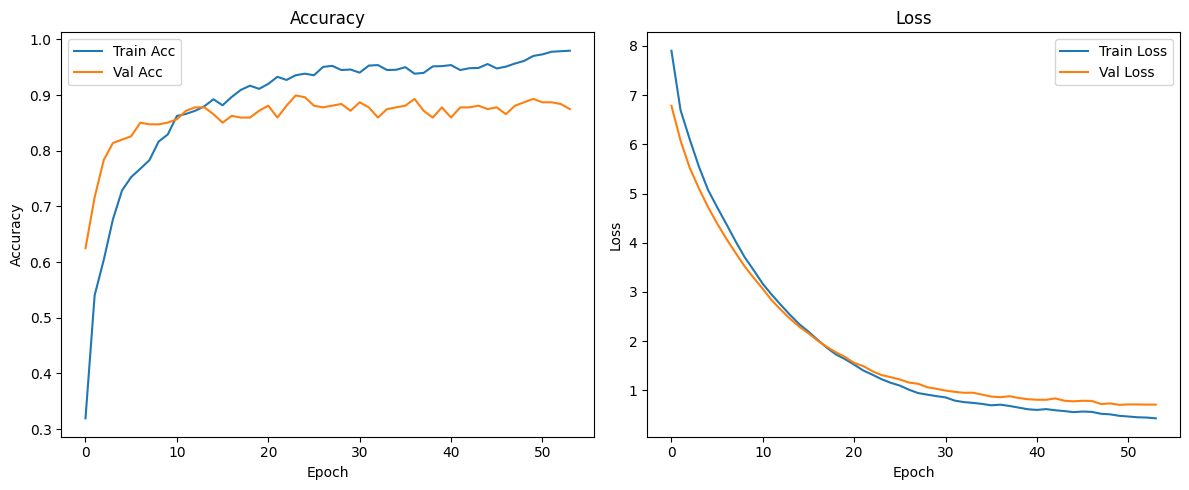

In [77]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        82
           1       0.88      0.85      0.86       108
           2       0.90      0.87      0.88        70
           3       0.81      0.84      0.82        74
           4       0.85      0.78      0.82        68
           5       0.59      0.59      0.59        29

    accuracy                           0.83       431
   macro avg       0.81      0.80  

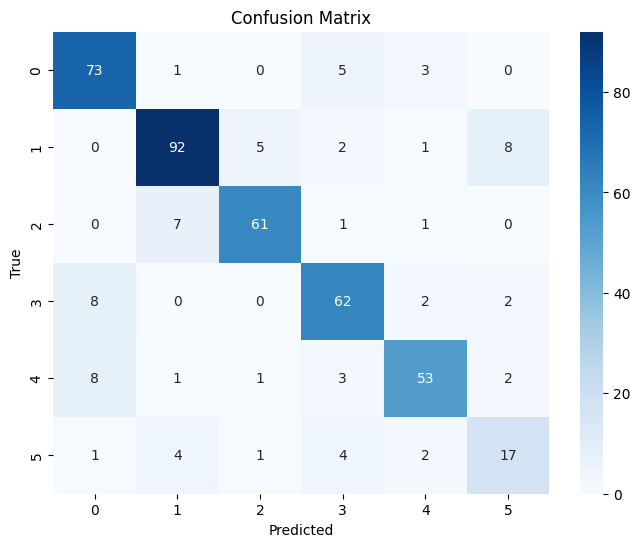

ROC AUC Score (macro): 0.9765
F1 Score (macro): 0.8033


In [78]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred_probs.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true, num_classes=6), y_pred_probs, multi_class='ovr')
print(f"ROC AUC Score (macro): {roc_auc:.4f}")

f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

In [79]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)

model.load_weights("best_model.keras")

preds = model.predict(test_ds)
y_true = test_df['label'].values
y_pred = np.argmax(preds, axis=1)

print(classification_report(y_true, y_pred, digits=4))
print("ROC AUC Score (macro):", roc_auc_score(y_true, preds, multi_class="ovr"))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8963 - loss: 0.7027
Epoch 1: val_loss did not improve from 0.70628
67/67 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8954 - loss: 0.6920 - val_accuracy: 0.8750 - val_loss: 0.7563 - learning_rate: 1.0000e-05
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9292 - loss: 0.5841
Epoch 2: val_loss did not improve from 0.70628
67/67 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9287 - loss: 0.5877 - val_accuracy: 0.8872 - val_loss: 0.7522 - learning_rate: 1.0000e-05
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9517 - loss: 0.5240
Epoch 3: val_loss did not improve from 0.70628
67/67 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9475 - loss: 0.5416 - val_accuracy: 0.8659 - val_loss: 0.7800 - learning_rate: 3.0000e-06
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9502 - loss: 0.5329
Epoch 4: val_loss did not improve from 0.70628
67/67 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy

c:\Users\Istiak\Desktop\Waste_Recycle\Batman\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 114 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 809ms/step
              precision    recall  f1-score   support

           0     0.7935    0.8902    0.8391        82
           1     0.8636    0.8796    0.8716       108
           2     0.9375    0.8571    0.8955        70
           3     0.7922    0.8243    0.8079        74
           4     0.8525    0.7647    0.8062        68
           5     0.6296    0.5862    0.6071        29

    accuracy                         0.8306       431
   macro avg     0.8115    0.8004    0.8046       431
weighted avg     0.8325    0.8306    0.8302       431

ROC AUC Score (macro): 0.9742597035223906
F1 Score (macro): 0.8045756513758904
